In [344]:
# Import our dependencies
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import sklearn as slk
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [345]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.tree import DecisionTreeRegressor





Loading Data

In [346]:
# Load the CSV file into a DataFrame
census_df = pd.read_csv("Data/Five_Year_Data.csv")

In [347]:
# Display the first few rows of the DataFrame to verify it's loaded correctly
census_df.head()

,GEO_ID,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,...,Total Population,White,Black,American Indian,Asian,Pacific Islander,Hispanic/Latino,County,State,Year
0,0500000US01001,2.6,8.7,32.6,20.3,8.1,15.9,11.8,43368.0,24124.0,...,55200,76.9,19.1,0.3,1.0,0.1,2.8,Autauga County,Alabama,2018
1,0500000US01003,2.7,7.0,27.6,22.0,9.4,20.7,10.6,167712.0,93379.0,...,208107,86.3,9.5,0.7,0.8,0.0,4.5,Baldwin County,Alabama,2018
2,0500000US01005,8.2,18.8,35.7,18.1,7.0,7.8,4.4,20948.0,8720.0,...,25782,47.4,47.6,0.3,0.4,0.0,4.3,Barbour County,Alabama,2018
3,0500000US01007,5.7,11.1,47.3,18.6,5.8,7.6,3.9,18470.0,8099.0,...,22527,76.7,22.3,0.0,0.2,0.0,2.4,Bibb County,Alabama,2018
4,0500000US01009,7.5,12.4,34.0,21.4,12.0,8.1,4.5,45915.0,21346.0,...,57645,95.5,1.5,0.2,0.3,0.0,9.1,Blount County,Alabama,2018


In [348]:
census_df["Population (16+)"]

0         43368.0
1        167712.0
2         20948.0
3         18470.0
4         45915.0
           ...   
15648     32578.0
15649     19688.0
15650     15484.0
15651      6298.0
15652      5705.0
Name: Population (16+), Length: 15653, dtype: float64

In [349]:
# census_df["poverty_rate"] = 100 * (census_df["Poverty"] / census_df["Population (16+)"])

In [350]:
census_df.describe()[1:].T.style.background_gradient(cmap='YlOrRd')

,mean,std,min,25%,50%,75%,max
Below_9th_grade,56918.918329,205161.825643,0.000000,2361.000000,12156.000000,34748.000000,6922061.000000
9_12th_grade,5.291043,3.726868,0.000000,2.600000,4.300000,6.800000,41.200000
High_School_Grad,13.063994,11.522207,0.000000,5.700000,8.400000,13.500000,55.600000
Some_College,31.577193,8.395277,6.500000,25.000000,32.000000,37.900000,57.400000
Associate's_degree,19.015818,6.227962,1.100000,15.900000,20.300000,23.300000,45.200000
Bachelor's_degree,10.323388,4.014004,0.100000,7.800000,9.600000,12.000000,48.000000
Graduate_degree,13.278605,6.216281,0.600000,8.800000,12.400000,16.800000,45.700000
Population (16+),83349.850316,265688.847797,300.000000,8851.000000,20941.000000,54690.000000,8123894.000000
Employed,49625.999169,162863.855225,154.000000,4561.000000,10965.000000,30366.000000,4929863.000000
Median Household Income,56280.708554,15459.916119,17109.000000,46110.000000,54061.000000,63379.000000,170463.000000


In [351]:
# Drop the non-beneficial ID columns, 'GEO_ID' and 'COUNTY'.
census_df = census_df.drop(columns=['GEO_ID','County', 'Year'])
census_df.columns

Index(['Below_9th_grade', '9_12th_grade', 'High_School_Grad', 'Some_College',
       'Associate's_degree', 'Bachelor's_degree', 'Graduate_degree',
       'Population (16+)', 'Employed', 'Median Household Income',
       'Per capita Income', 'Unemployment Rate', 'Professional (Occupation)',
       'Service (Occupation)', 'Sales (Occupation)',
       'Construction (Occupation)', 'Production (Occupation)',
       'Salary (Class)', 'Gov't (Class)', 'Self-employed (Class)',
       'Fam-unpaid (Class)', 'Poverty', 'Child-poverty', 'Median Home value',
       'Median Mortgage', 'Median Rent', 'Total Population', 'White', 'Black',
       'American Indian', 'Asian', 'Pacific Islander', 'Hispanic/Latino',
       'State'],
      dtype='object')

In [352]:
# Determine the number of unique values in each column.
census_df.nunique()

Below_9th_grade              11458
9_12th_grade                   252
High_School_Grad               506
Some_College                   444
Associate's_degree             339
Bachelor's_degree              315
Graduate_degree                379
Population (16+)             13965
Employed                     12842
Median Household Income      13138
Per capita Income            11473
Unemployment Rate              214
Professional (Occupation)      483
Service (Occupation)           307
Sales (Occupation)             254
Construction (Occupation)      308
Production (Occupation)        367
Salary (Class)                 495
Gov't (Class)                  430
Self-employed (Class)          305
Fam-unpaid (Class)              64
Poverty                        410
Child-poverty                  593
Median Home value             3335
Median Mortgage               1758
Median Rent                   1373
Total Population             14215
White                          839
Black               

In [353]:
# Convert "Popultion (16+)", 'Employed', 'Below_9th_grade' to percentage of Total Population
convert = ['Population (16+)', 'Employed', 'Below_9th_grade']
census_df[convert] = census_df[convert].div(census_df['Total Population'], axis='index')*100

In [354]:
# combine Asian, Pacyfic Islander, and American to other
census_df['RaceOther'] = census_df['Asian'] + census_df['Pacific Islander'] + census_df['American Indian']
census_df = census_df.drop(['Asian', 'Pacific Islander', 'American Indian'], axis=1)

In [355]:
census_df.head()

,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,Median Household Income,...,Child-poverty,Median Home value,Median Mortgage,Median Rent,Total Population,White,Black,Hispanic/Latino,State,RaceOther
0,0.004710,8.7,32.6,20.3,8.1,15.9,11.8,78.565217,43.702899,58786.0,...,22.7,147900.0,1176.0,966.0,55200,76.9,19.1,2.8,Alabama,1.4
1,0.001297,7.0,27.6,22.0,9.4,20.7,10.6,80.589312,44.870667,55962.0,...,13.4,189800.0,1359.0,958.0,208107,86.3,9.5,4.5,Alabama,1.5
2,0.031805,18.8,35.7,18.1,7.0,7.8,4.4,81.250485,33.822046,34186.0,...,47.6,92900.0,950.0,590.0,25782,47.4,47.6,4.3,Alabama,0.7
3,0.025303,11.1,47.3,18.6,5.8,7.6,3.9,81.990500,35.952413,45340.0,...,20.2,96500.0,1093.0,714.0,22527,76.7,22.3,2.4,Alabama,0.2
4,0.013011,12.4,34.0,21.4,12.0,8.1,4.5,79.651314,37.030098,48695.0,...,21.6,124700.0,1100.0,662.0,57645,95.5,1.5,9.1,Alabama,0.5


In [356]:
# Move the target column to the last
columns = list(census_df.columns.values)
columns.pop(columns.index('Poverty'))
census_df = census_df[columns+['Poverty']]
census_df.head()

,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,Median Household Income,...,Median Home value,Median Mortgage,Median Rent,Total Population,White,Black,Hispanic/Latino,State,RaceOther,Poverty
0,0.004710,8.7,32.6,20.3,8.1,15.9,11.8,78.565217,43.702899,58786.0,...,147900.0,1176.0,966.0,55200,76.9,19.1,2.8,Alabama,1.4,15.4
1,0.001297,7.0,27.6,22.0,9.4,20.7,10.6,80.589312,44.870667,55962.0,...,189800.0,1359.0,958.0,208107,86.3,9.5,4.5,Alabama,1.5,10.6
2,0.031805,18.8,35.7,18.1,7.0,7.8,4.4,81.250485,33.822046,34186.0,...,92900.0,950.0,590.0,25782,47.4,47.6,4.3,Alabama,0.7,28.9
3,0.025303,11.1,47.3,18.6,5.8,7.6,3.9,81.990500,35.952413,45340.0,...,96500.0,1093.0,714.0,22527,76.7,22.3,2.4,Alabama,0.2,14.0
4,0.013011,12.4,34.0,21.4,12.0,8.1,4.5,79.651314,37.030098,48695.0,...,124700.0,1100.0,662.0,57645,95.5,1.5,9.1,Alabama,0.5,14.4


Visualization

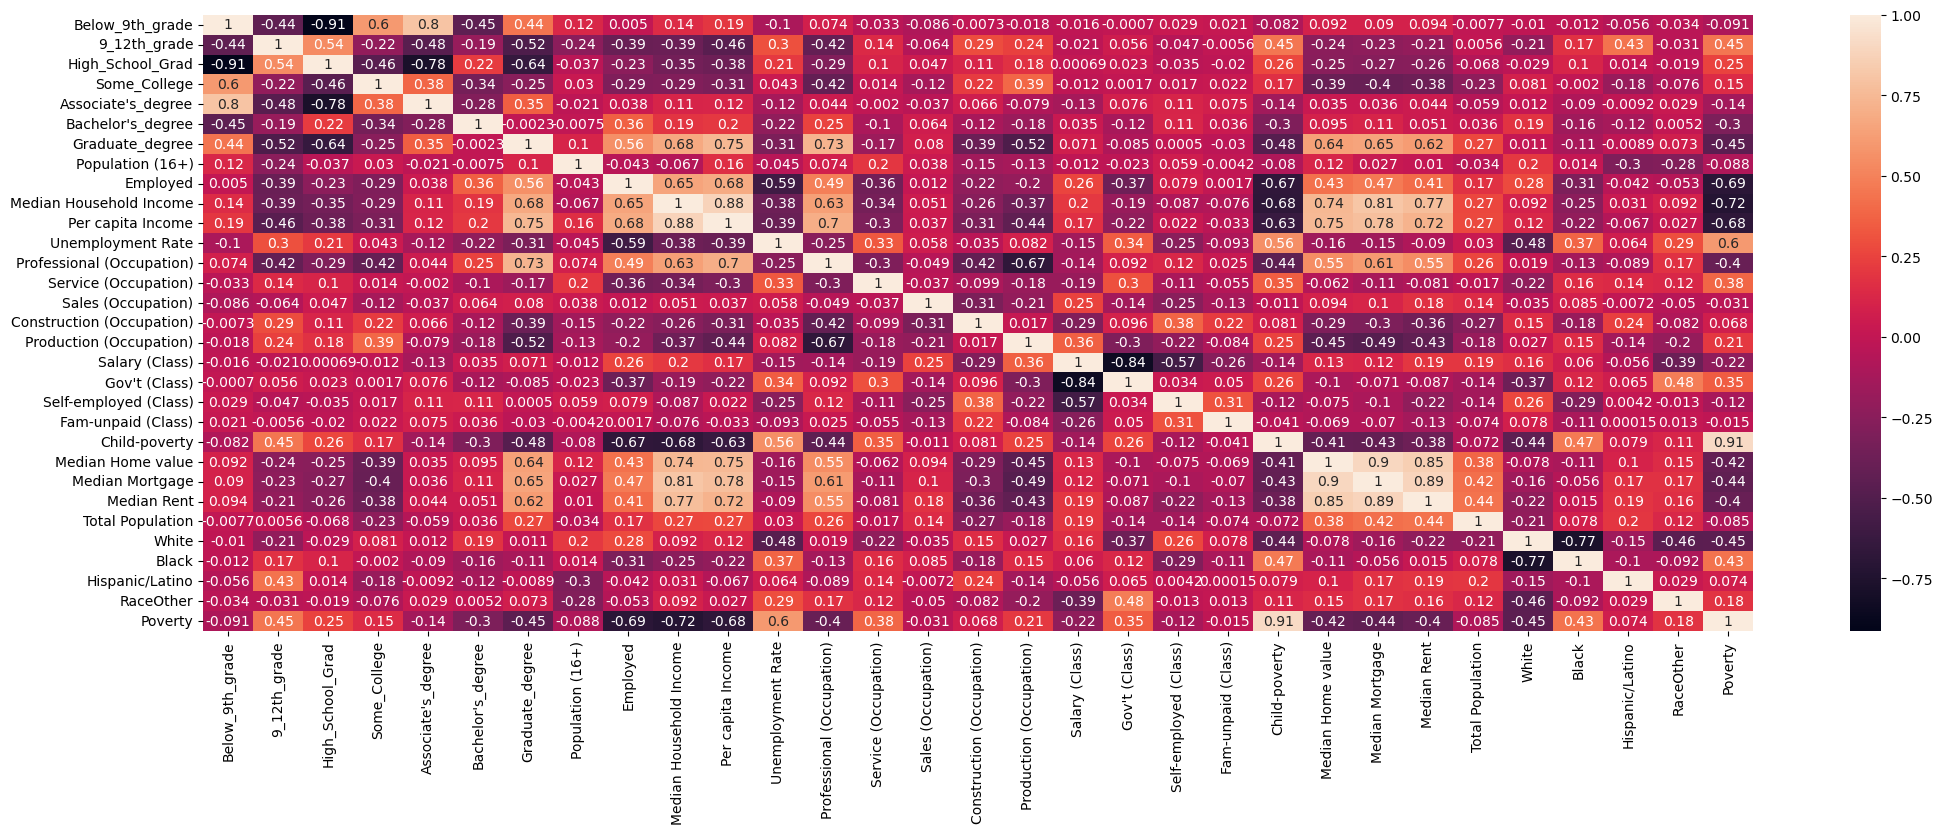

In [357]:
# Correlation Matrix
plt.figure(figsize=(25,8))
sns.heatmap(census_df.drop(columns="State").corr(),annot=True)
plt.show()

In [358]:
census_df = census_df.drop(columns=['Child-poverty', 'Median Mortgage', 'Median Rent', 'Per capita Income','State'])
census_df.columns

Index(['Below_9th_grade', '9_12th_grade', 'High_School_Grad', 'Some_College',
       'Associate's_degree', 'Bachelor's_degree', 'Graduate_degree',
       'Population (16+)', 'Employed', 'Median Household Income',
       'Unemployment Rate', 'Professional (Occupation)',
       'Service (Occupation)', 'Sales (Occupation)',
       'Construction (Occupation)', 'Production (Occupation)',
       'Salary (Class)', 'Gov't (Class)', 'Self-employed (Class)',
       'Fam-unpaid (Class)', 'Median Home value', 'Total Population', 'White',
       'Black', 'Hispanic/Latino', 'RaceOther', 'Poverty'],
      dtype='object')

In [359]:
# # Check for missing values and remove them
print(census_df.isnull().sum())
data = census_df.dropna()

# # # Identify non-numeric columns
non_numeric_cols = census_df.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_cols}")

Below_9th_grade              0
9_12th_grade                 0
High_School_Grad             0
Some_College                 0
Associate's_degree           0
Bachelor's_degree            0
Graduate_degree              0
Population (16+)             0
Employed                     0
Median Household Income      0
Unemployment Rate            0
Professional (Occupation)    0
Service (Occupation)         0
Sales (Occupation)           0
Construction (Occupation)    0
Production (Occupation)      0
Salary (Class)               0
Gov't (Class)                0
Self-employed (Class)        0
Fam-unpaid (Class)           0
Median Home value            0
Total Population             0
White                        0
Black                        0
Hispanic/Latino              0
RaceOther                    0
Poverty                      0
dtype: int64
Non-numeric columns: Index([], dtype='object')


In [360]:
# Applying Label Encoding or One-Hot Encoding
label_encoder = LabelEncoder()

for col in non_numeric_cols:
    if census_df[col].nunique() <= 10:  
        census_df    [col] = label_encoder.fit_transform(census_df[col])
    else:  # Otherwise, use one-hot encoding
        census_df = pd.get_dummies(census_df, columns=[col])

###  Split the data into training and testing datasets by using `train_test_split`.

In [361]:
y = census_df['Poverty']

In [362]:
feature_cols_to_drop = ['Poverty']
X = census_df.drop(columns=feature_cols_to_drop)
print(X.shape)
X.head()

(15653, 26)


,Below_9th_grade,9_12th_grade,High_School_Grad,Some_College,Associate's_degree,Bachelor's_degree,Graduate_degree,Population (16+),Employed,Median Household Income,...,Salary (Class),Gov't (Class),Self-employed (Class),Fam-unpaid (Class),Median Home value,Total Population,White,Black,Hispanic/Latino,RaceOther
0,0.004710,8.7,32.6,20.3,8.1,15.9,11.8,78.565217,43.702899,58786.0,...,73.2,21.0,5.6,0.1,147900.0,55200,76.9,19.1,2.8,1.4
1,0.001297,7.0,27.6,22.0,9.4,20.7,10.6,80.589312,44.870667,55962.0,...,80.0,13.2,6.7,0.1,189800.0,208107,86.3,9.5,4.5,1.5
2,0.031805,18.8,35.7,18.1,7.0,7.8,4.4,81.250485,33.822046,34186.0,...,75.6,18.5,5.7,0.2,92900.0,25782,47.4,47.6,4.3,0.7
3,0.025303,11.1,47.3,18.6,5.8,7.6,3.9,81.990500,35.952413,45340.0,...,77.8,16.0,5.5,0.7,96500.0,22527,76.7,22.3,2.4,0.2
4,0.013011,12.4,34.0,21.4,12.0,8.1,4.5,79.651314,37.030098,48695.0,...,83.2,11.8,4.8,0.2,124700.0,57645,95.5,1.5,9.1,0.5


In [363]:
X.isna().sum()


Below_9th_grade              0
9_12th_grade                 0
High_School_Grad             0
Some_College                 0
Associate's_degree           0
Bachelor's_degree            0
Graduate_degree              0
Population (16+)             0
Employed                     0
Median Household Income      0
Unemployment Rate            0
Professional (Occupation)    0
Service (Occupation)         0
Sales (Occupation)           0
Construction (Occupation)    0
Production (Occupation)      0
Salary (Class)               0
Gov't (Class)                0
Self-employed (Class)        0
Fam-unpaid (Class)           0
Median Home value            0
Total Population             0
White                        0
Black                        0
Hispanic/Latino              0
RaceOther                    0
dtype: int64

In [364]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

In [365]:
# Create a StandardScaler instances
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression

In [366]:
# # Create a model
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_train_pred = lin_model.predict(X_train_scaled)


PCA

In [367]:
components = 17
pca = PCA(n_components=components)
pca_X_train = pca.fit_transform(X_train_scaled)
pca_X_text = pca.transform(X_test_scaled)

X_test_scaled.shape

(3914, 26)

## Compile, Train and Evaluate the Model

In [368]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train_scaled[0])
hidden_layer1 = 100
hidden_layer2 = 50
hidden_layer3 = 25

nn = tf.keras.models.Sequential()
# First hidden layer,
nn.add(tf.keras.layers.Dense(units=hidden_layer1, input_dim=input_features,activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

c:\Users\eweli\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 100)            │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,051 (35.36 KB)

 Trainable params: 9,051 (35.36 KB)

 Non-trainable params: 0 (0.00 B)

Decision Tree

In [369]:
model = DecisionTreeRegressor()
model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [370]:
y_pred = model.predict(X_test_scaled)

R2 Score 0.6864162929548454
Mean Squeared Error:11.216308124680635
Root Mean Squared Error: 3.349075711995869


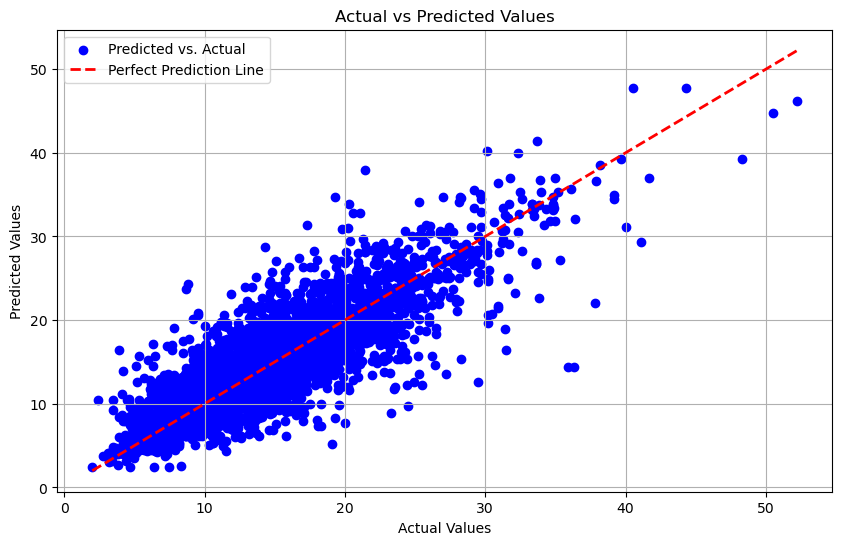

In [371]:
r2 =  r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2 Score {r2}")
print(f"Mean Squeared Error:{mse}")
print(f"Root Mean Squared Error: {rmse}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [372]:
# Compilt the model
nn.compile(loss="mse", optimizer="adam", metrics=["R2Score"])

In [373]:
# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [374]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: -22.2372
Epoch 2/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: -100.1013
Epoch 3/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -165.4919
Epoch 4/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -241.6407
Epoch 5/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -320.9269
Epoch 6/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -403.6158
Epoch 7/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -488.1434
Epoch 8/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -568.3939
Epoch 9/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: -645.9109
Epoch 10/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: -719.7902
Epoch 11/100
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu